In [5]:
#<GRADED>
import numpy as np
from numpy.matlib import repmat
import sys
import time
from l2distance import l2distance
import visclassifier
import matplotlib
#matplotlib.use('PDF')
import matplotlib.pyplot as plt

from scipy.stats import linregress

import pylab
from matplotlib.animation import FuncAnimation

#new torch imports
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

#misc imports
import random
#</GRADED>

%matplotlib notebook

<!--announcements-->
<blockquote>
    <center>
    <img src="yinyang.png" width="400px" /></a>
    </center>
      <p><cite><center>"Just as we have two eyes and two feet,<br>
      duality is part of life."<br>
<b>--Carlos Santana</b><br>
      </center></cite></p>
</blockquote>


<h3>Introduction</h3>
In this project, you will implement a linear support vector machine and one operating in kernel space. For this you will need to formulate the primal and dual optimization problems as quadratic programs. For this, we will be dipping into the shallow end with Course staffs' favorite ML framework: PyTorch!

For full documentation and details, here is their site https://pytorch.org/. PyTorch is an open source machine learning library based on the Torch library, used for applications such as computer vision and natural language processing, primarily developed by Facebook's AI Research lab. Pytorch is very neat because, as you have seen your assignments, in order to do gradient descent we've had to calculate gradient manually. No more! Pytorch performs automatic differentation, as long as we use their functions in our code.

Note: Because we are working with Pytorch functions and Modules, we will be using excusively Pytorch tensors instead of numpy arrays. This allows us to multiply/use torch parameter objects with our data directly. Pytorch tensors carry most of the same functionality as numpy arrays. 

We will start with a simple example of PyTorch, where we use gradient descent to find the parameters of a simple linear regression problem.

In [28]:
def gen_regression_data(num_samples = 10000, ndims=1):
    # generate random x samples for training and test sets
    xTr = torch.rand(num_samples, ndims)
    xTe = torch.rand(int(num_samples * 0.1), ndims)
    
    # choose some w and b vectors
    gt_w = torch.ones(ndims, 1)
    gt_b = torch.randn(1)
    
    # gaussian noise for linear regression
    noise = np.random.rand(num_samples, 1) * 0.2
    test_noise = np.random.rand(int(num_samples * 0.1), 1) * 0.2
    
    # add noise on the labels for the training set
    yTr = xTr @ gt_w + gt_b + noise
    yTe = xTe @ gt_w + gt_b + test_noise
    
    return xTr, xTe, yTr, yTe, gt_w, gt_b

In [29]:
lr_xTr, lr_xTe, lr_yTr, lr_yTe, gt_w, gt_b = gen_regression_data(num_samples = 1000, ndims=1)

Now we will create our PyTorch model. PyTorch models inherit the class torch.nn.module, and you need to implement the function forward which is equivalent to a forward pass. Usually, you feed in batch of x samples as input and you get batch of outputs, but you could pass other parameters as well if needed. Every torch module will implement two functions. __init__ its constructor, and __forward__ which defines what happens when you call the module.

Note we define two fields of the <code>LinearRegressionModel</code>:
* <code>self.w</code>: The weight vector of the linear regression model. This is updated automatically by Pytorch in our training loop because we define it as a nn.Parameter (note requires_grad=True). Additionally <code>torch.randn(ndims, 1)</code> gives us an initialization for this weight vector.
* <code>self.b</code>: The bias of the linear regression model. This is also updated automatically by Pytorch in our training loop.

In [30]:
class LinearRegressionModel(nn.Module):
    def __init__(self, ndims):
        super(LinearRegressionModel, self).__init__()
        """ pytorch optimizer checks for the properties of the model, and if
            the torch.nn.Parameter requires gradient, then the model will update
            the parameters automatically.
        """
        self.w = nn.Parameter(torch.randn(ndims, 1), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)
    
    def forward(self, x):
        return x @ self.w + self.b

For this example we use our familiar mean-squared error loss.

In [31]:
def mse_loss(y_pred, y_true):
    square_diff = torch.pow((y_pred-y_true), 2)
    mean_error = 0.5 * torch.mean(square_diff)
    return mean_error

Here is a generic training loop in Pytorch, this will be very useful for you in your assignment. We have supplied comments per line to help walk you through what each different part does.

In [32]:
def train_regression_model(xTr, yTr, num_epochs, reg_param, lr=1e-2, print_freq=100):
    ndims = xTr.shape[1]
    
    model = LinearRegressionModel(ndims)  # initialize the model
    optimizer = optim.SGD(model.parameters(), lr=lr)  # create an SGD optimizer for the model parameters
    
    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        optimizer.zero_grad()  
        pred = model.forward(xTr)  # compute model predictions
        loss = mse_loss(pred, yTr) + reg_param * torch.norm(model.w)**2
        loss.backward()  # compute the gradient wrt loss
        optimizer.step()  # performs a step of gradient descent
        if (epoch + 1) % print_freq == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    
    return model  # return trained model

In [33]:
model = train_regression_model(lr_xTr, lr_yTr, num_epochs=2000, reg_param=0.001, lr=0.1)
avg_test_error = mse_loss(model.forward(lr_xTe), lr_yTe)
print('avg test error', avg_test_error.item())

epoch 100 loss 0.004668959976596606
epoch 200 loss 0.0031790100815914674
epoch 300 loss 0.0027790460504999526
epoch 400 loss 0.002671678056638368
epoch 500 loss 0.002642856025220397
epoch 600 loss 0.0026351189754552306
epoch 700 loss 0.002633042019824728
epoch 800 loss 0.002632484360512191
epoch 900 loss 0.0026323345541143517
epoch 1000 loss 0.002632294366595383
epoch 1100 loss 0.002632283660392239
epoch 1200 loss 0.0026322808355829916
epoch 1300 loss 0.002632280027171821
epoch 1400 loss 0.002632279813831925
epoch 1500 loss 0.00263227970411247
epoch 1600 loss 0.0026322797893929446
epoch 1700 loss 0.0026322797038045246
epoch 1800 loss 0.002632279752325054
epoch 1900 loss 0.002632279752325054
epoch 2000 loss 0.002632279752325054
avg test error 0.0019245955536923937


Now, we have a trained model object that we can predict with by passing in input data via model.forward(x). Let's visualize how good of a fit our line is to the data!

In [35]:
plt.plot(lr_xTr, model.forward(lr_xTr).detach(),linewidth=5.0, color="red", label="Prediction Line")
plt.scatter(lr_xTr, lr_yTr, label="Train Points")
plt.scatter(lr_xTe, lr_yTe, label="Test Points")
plt.legend()
plt.show()

For the following assignment there are a bunch of PyTorch specfic functions that we believe will be very helpful for you. Those are:

* <code>torch.clamp(input, min=None, max=None, *, out=None) </code>: Clamps all elements in input into the range [min, max]

* <code>torch.sum(input, *, dtype=None) </code>: Returns the sum of all elements in the input tensor.

* <code>torch.mean(input, *, dtype=None)</code>: Returns the mean value of all elements in the input tensor.

* <code>torch.pow(input, exponent, *, out=None)</code>: Takes the power of each element in input with exponent and returns a tensor with the result.

* <code>torch.exp(input, *, out=None)</code>: Returns a new tensor with the exponential of the elements of the input tensor.

<h3> Linear classification</h3>

<p> The first part of the assignment is to implement a linear support vector machine. In order to do this, we are going to generate random data to classify:
</p>

In [36]:
def genrandomdata(n=100,b=0.):
    # generate random data and linearly separable labels
    xTr = np.random.randn(n, 2)
    # defining random hyperplane
    w0 = np.random.rand(2, 1)
    # assigning labels +1, -1 labels depending on what side of the plane they lie on
    yTr = np.sign(np.dot(xTr, w0)+b).flatten()
    return torch.from_numpy(xTr).float(), torch.from_numpy(yTr).float()

<p>Remember the SVM formulation
$$\begin{aligned}
             &\min_{\mathbf{w},b,\xi} \|\mathbf{w}\|^2_2+C \sum_{i=1}^n \xi_i\\
       & \text{such that }  \ \forall i:\\
             & y_i(\mathbf{w}^\top \mathbf{x}_i+b)\geq 1-\xi_i\\
             & \xi_i\geq 0.\\
\end{aligned}
$$
This is called the "primal" formulation in contrast with the "dual" formulation we'll see later in this assignment. Recall that this is equivalent to the unconstrained formulation in terms of the hinge loss which we saw in <a href="https://www.cs.cornell.edu/courses/cs4780/2022sp/notes/LectureNotes13.html">Lecture 13</a>.

Use the hinge loss to implement the function <code>primalSVM</code>, which takes in training data <code>xTr</code> (of shape $n\times d$) and labels <code>yTr</code> (of shape $n$) with <code>yTr[i]</code>$\in \{-1,1\}$. Note that we aren't doing linear programming: this is gradient descent optimization on the unconstrained hinge loss formulation so the constraints are something we do not worry about.</p>

To warm up, implement <code>hinge_loss</code>. This function should be used to compute the loss
$$\max\left( 1-y_{i}(\mathbf{w}^T \mathbf{x}+b),0 \right)$$
where `y_pred` takes on the value of $\mathbf{w}^T \mathbf{x} + b$. Working with torch tensors is a lot like working with numpy tensors, think about the best way to do tensor on tensor operations. <b>This method requires no loops</b>.

Hint: <code>torch.clamp</code> might be useful here

In [37]:
#<GRADED>
def hinge_loss(y_pred, y_true):
    y_pred = torch.squeeze(y_pred)
    fun = 1 - y_pred * y_true
    loss = torch.clamp(fun, min = 0)
    loss = torch.sum(loss)
    return loss
#</GRADED>

Next, implement <code>LinearSVM</code>. This is a module (similar to the one in the example above) which initializes a linear classifer in dimension <code>dim</code>. In this module, you will need to initialize the necessary parameters for a linear model and define the forward pass for an input $x$, which should produce the output `y_pred` that the `hinge_loss` function takes as input. Hint: It <b>should</b> look very similar to what you have done before.

In [214]:
#<GRADED>
class LinearClassifier(nn.Module):
    """Support Vector Machine"""

    def __init__(self, dim):
        super(LinearClassifier, self).__init__()
        self.w = nn.Parameter(torch.randn(dim), requires_grad=True)
        self.b = nn.Parameter(torch.randn(1), requires_grad=True)

    def forward(self, x):
        return x @ self.w + self.b
#</GRADED>

Finally, implement <code>primalSVM</code>. This is a method which takes in a set of training data <code>xTr</code> and labels <code>yTr</code>, a number of epochs <code>num_epochs</code> to train for, and our SVM <code>C</code> hyper-parameter. You should return a lambda function <code>svmclassify</code> that produces a forward pass of your trained model.

In [215]:
#<GRADED>
def primalSVM(xTr, yTr, num_epochs=1000, C=1):
    ndims = xTr.shape[1]
    
    svmclassify = LinearClassifier(ndims)  # initialize the model
    optimizer = optim.SGD(svmclassify.parameters(), lr=1e-2)  # create an SGD optimizer for the model parameters
    
    for epoch in range(num_epochs):
        # need to zero the gradients in the optimizer so we don't
        # use the gradients from previous iterations
        optimizer.zero_grad()  
        pred = svmclassify.forward(xTr)  # compute model predictions
        loss = C*hinge_loss(pred, yTr) +  ((svmclassify.w).T@(svmclassify.w))
        loss.backward()  # compute the gradient wrt loss
        optimizer.step()  # performs a step of gradient descent
        if (epoch + 1) % 100 == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    return svmclassify
#</GRADED>

We can test your SVM primal solver with the following randomly generated data set. We label it in a way that it is guaranteed to be linearly separable. If your code works correctly the hyper-plane should separate all the $x$'s into the red half and all the $o$'s into the blue half. With sufficiently large values of $C$ (e.g. $C>10$) you should obtain $0\%$ training error. 

2
epoch 100 loss 144.85433959960938
epoch 200 loss 173.53030395507812
epoch 300 loss 189.80426025390625
epoch 400 loss 230.86602783203125
epoch 500 loss 125.60484313964844
epoch 600 loss 231.33811950683594
epoch 700 loss 125.27200317382812
epoch 800 loss 159.67529296875
epoch 900 loss 138.3794403076172
epoch 1000 loss 127.93124389648438


<IPython.core.display.Javascript object>


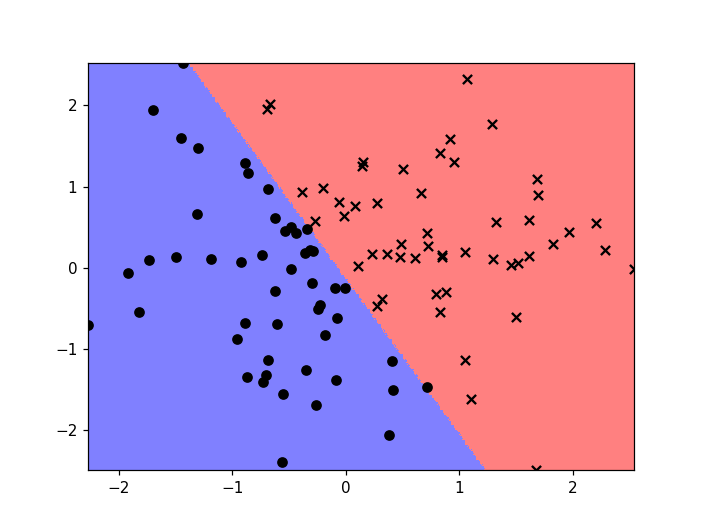

Training error: 1.0%


In [173]:
xTr,yTr = genrandomdata()
fun = primalSVM(xTr,yTr,C=15)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean((torch.sign(fun(xTr))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

### Spiral data set

<p>The linear classifier works great in simple linear cases. But what if the data is more complicated? We provide you with a "spiral" data set. You can load it and visualize it with the following two code snippets:
<pre>

In [41]:
def spiraldata(N=300):
    r = np.linspace(1,2*np.pi,N)
    xTr1 = np.array([np.sin(2.*r)*r, np.cos(2*r)*r]).T
    xTr2 = np.array([np.sin(2.*r+np.pi)*r, np.cos(2*r+np.pi)*r]).T
    xTr = np.concatenate([xTr1, xTr2], axis=0)
    yTr = np.concatenate([np.ones(N), -1 * np.ones(N)])
    xTr = xTr + np.random.randn(xTr.shape[0], xTr.shape[1])*0.2
    
    xTe = xTr[::2,:]
    yTe = yTr[::2]
    xTr = xTr[1::2,:]
    yTr = yTr[1::2]
    
    xTr = torch.tensor(xTr).float()
    yTr = torch.tensor(yTr).float()
    xTe = torch.tensor(xTe).float()
    yTe = torch.tensor(yTe).float()
            
    vals, indices = torch.max(xTr, dim=0, keepdim=True)
    xTr /= (vals * 2.0)
    vals, indices = torch.max(xTe, dim=0, keepdim=True)
    xTe /= (vals * 2.0)
    
    return xTr,yTr,xTe,yTe

<IPython.core.display.Javascript object>


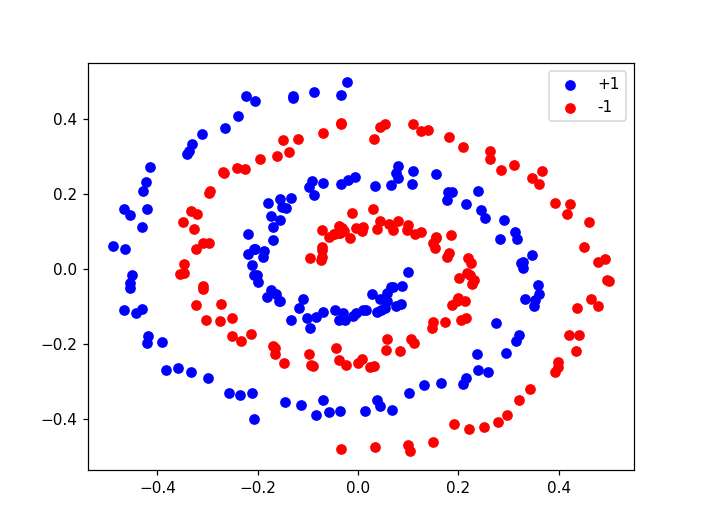

In [42]:
xTr,yTr,xTe,yTe=spiraldata()
plt.figure()
plt.scatter(xTr[yTr == 1, 0], xTr[yTr == 1, 1], c='b')
plt.scatter(xTr[yTr != 1, 0], xTr[yTr != 1, 1], c='r')
plt.legend(["+1","-1"])
plt.show()

<p>If you apply your previously functioning linear classifier on this data set you will see that you get terrible results. Your training error will increase drastically. </p>

epoch 100 loss 10176.3466796875
epoch 200 loss 9116.34375
epoch 300 loss 12144.701171875
epoch 400 loss 11373.1337890625
epoch 500 loss 11373.154296875
epoch 600 loss 11373.1630859375
epoch 700 loss 11373.1689453125
epoch 800 loss 11373.1767578125
epoch 900 loss 11373.18359375
epoch 1000 loss 11373.1904296875


<IPython.core.display.Javascript object>


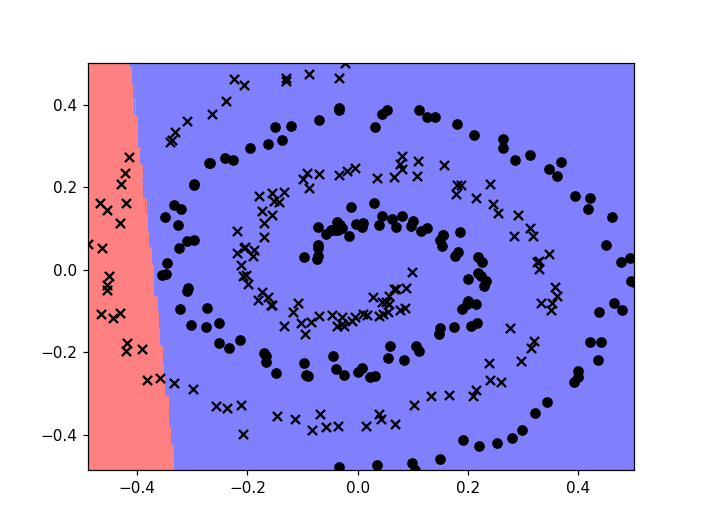

Training error: 43.3%


In [43]:
fun=primalSVM(xTr,yTr,C=10)
visclassifier.visclassifier(fun,xTr,yTr)
err=torch.mean(((torch.sign(fun(xTr)))!=yTr).float())
print("Training error: %2.1f%%" % (err*100))

<h3>Implementing a kernelized SVM</h3>

<p> For a data set as complex as the spiral data set, you will need a more complex classifier. 
First implement the kernel function
<pre>	computeK(kernel_type,X,Z,kpar)</pre>
It takes as input a kernel type <code>kernel_type</code> and two data sets $\mathbf{X} \in \mathcal{R}^{n\times d}$ and $\mathbf{Z} \in \mathcal{R}^{m\times d}$ and outputs a kernel matrix $\mathbf{K}\in{\mathcal{R}^{n\times m}}$. The last input, <code>kpar</code> specifies the kernel parameter (e.g. the inverse kernel width $\gamma$ in the RBF case or the degree $p$ in the polynomial case.)
	<ol>
	<li>For the linear kernel (<code>kernel_type='linear'</code>) svm, use $k(\mathbf{x},\mathbf{z})=x^Tz$ </li> 
	<li>For the radial basis function kernel (<code>kernel_type='rbf'</code>) svm use $k(\mathbf{x},\mathbf{z})=\exp(-\gamma ||x-z||^2)$ (gamma is a hyperparameter, passed as the value of kpar)</li>
	<li>For the polynomial kernel (<code>kernel_type='poly'</code>) use  $k(\mathbf{x},\mathbf{z})=(x^Tz + 1)^d$ (d is the degree of the polymial, passed as the value of kpar)</li>
</ol>

<p>You can use the function <b><code>l2distance</code></b> as a helperfunction, which is located in defined in one of your starter files l2distance.py.</p>

In [44]:
#<GRADED>
def computeK(kernel_type, X, Z, kpar=0):
    """
    function K = computeK(kernel_type, X, Z)
    computes a matrix K such that Kij=k(x,z);
    for three different function linear, rbf or polynomial.
    
    Input:
    kernel_type: either 'linear','polynomial','rbf'
    X: n input vectors of dimension d (nxd);
    Z: m input vectors of dimension d (mxd);
    kpar: kernel parameter (inverse kernel width gamma in case of RBF, degree in case of polynomial)
    
    OUTPUT:
    K : nxm kernel Torch float tensor
    """
    assert kernel_type in ["linear","polynomial","poly","rbf"], "Kernel type %s not known." % kernel_type
    assert X.shape[1] == Z.shape[1], "Input dimensions do not match"
    K = 0
    dist = l2distance(X,Z)
    if (kernel_type=='linear'):
        K = torch.matmul(X,Z.T)
    if (kernel_type=='rbf'):
        val = torch.pow(dist, 2)
        K = torch.exp(-kpar*val)
    if (kernel_type=='polynomial'):
        val = torch.matmul(X,Z.T)
        K = torch.pow((val + 1),kpar)
    
    return K
#</GRADED>

<p>The following code snippet plots an image of the kernel matrix for the data points in the spiral set. Use it to test your <b><code>computeK</code></b> function:</p>

In [45]:
xTr,yTr,xTe,yTe=spiraldata()
K=computeK("poly",xTr,xTr,kpar=0.05)
# plot an image of the kernel matrix
plt.figure()
plt.pcolormesh(K, cmap='jet')
plt.show()

<IPython.core.display.Javascript object>

ValueError: not enough values to unpack (expected 2, got 0)

A SVM with feature transformation $\phi$ with associated kernel function $k$ (producing kernel matrix $K \in \mathbb{R}^{n \times n}$ with $K_{ij} = k(\mathbf{x}_i, \mathbf{x}_j)$) would have the objective
$$
    \ell(\mathbf{w}, b) = \| \mathbf{w} \|_2^2 + C\sum_{i=1}^n \max(1-y_i(\mathbf{w}^\top\phi(\mathbf{x}_i)+b),0).
$$
If we initialize $\mathbf{w}$ to zero in gradient descent, it's not too hard to see that the gradients of $\ell$ with respect to $\mathbf{w}$ all lie in the span of $\phi(\mathbf{x}_i)$ (i.e. they can all be written as linear combinations of the transformed feature vectors). Let's leverage this to do a reparameterization, just like we did in lecture. Set
$$\mathbf{w} = \sum_{i=1}^n \beta_i \phi(\mathbf{x}_i)$$
for new parameter $\beta \in \mathbb{R}^n$. Then, we can see that the squared-norm of $\mathbf{w}$ is
$$\begin{aligned} \| \mathbf{w} \|_2^2 &= \mathbf{w}^T \mathbf{w} \\&= \left( \sum_{i=1}^n \beta_i \phi(\mathbf{x}_i) \right)^T \left( \sum_{j=1}^n \beta_j \phi(\mathbf{x}_j) \right) \\&= \sum_{i=1}^n \sum_{j=1}^n \beta_i \beta_j \phi(\mathbf{x}_i)^T \phi(\mathbf{x}_j) \\&= \sum_{i=1}^n \sum_{j=1}^n \beta_i \beta_j k(\mathbf{x}_i, \mathbf{x}_j) \\&= \sum_{i=1}^n \sum_{j=1}^n \beta_i \beta_j K_{ij} \\&= \beta^T K \beta. \end{aligned}$$
Similarly,
$$\mathbf{w}^\top\phi(\mathbf{x}_i) = \sum_{j=1}^n \beta_j \phi(\mathbf{x}_j)^T \phi(\mathbf{x}_i) = \sum_{j=1}^n \beta_j K_{ji} = \beta^T k_i$$
where $k_i = Ke_i$ is the $i$th column of the kernel matrix $K$.
This would yield the objective
$$
    \ell(\mathbf{w}, b) = \beta^T K \beta + C\sum_{i=1}^n \max(1-y_i(\beta^T k_i + b),0).
$$

----

As an aside, this transformation can be compared to the classic Lagrange "dual" formulation of the original SVM problem.
$$\begin{aligned}
             \mbox{minimize }& \frac{1}{2} \sum_{i,j}\alpha_i \alpha_j y_i y_j K_{ij} - \sum_{i=1}^{n}\alpha_i  \\
             \mbox{over }& \alpha \in \mathbb{R}^n \\
             \mbox{subject to }& 0 \leq \alpha_i \leq C\\
             & \sum_{i=1}^{n} \alpha_i y_i = 0.
\end{aligned}$$
<a href="https://en.wikipedia.org/wiki/Duality_(optimization)">"Duality" of this sort</a> is a core concept in optimization, although not one that we cover in CS4/5780.
This dual program is equivalent to solving for the SVM "primal" where $\mathbf{w}=\sum_{i=1}^n y_i \alpha_i \phi(\mathbf{x}_i)$ and $\mathbf{K}_{ij}=k(\mathbf{x}_i,\mathbf{x}_j)=\phi(\mathbf{x}_i)^\top\phi(\mathbf{x}_j)$, for the feature transformation $\phi(\cdot)$. This produces the same result as our analysis above after a change of variable, with $\beta_i = \alpha_iy_i$ and $\beta \in R^n$ (although it takes a bit of derivation to see why, and this sort of duality is beyond the scope of this course). For this reason, this sort of formulation of the kernelized SVM &mdash; where the optimization is done over a space of size $n$ rather than $d$ &mdash; is usually called the <b>"dual SVM."</b>

----

Often, when we use a dual SVM in this way, the hinge loss is replaced with the <b>squared hinge loss</b>. This usually results in a similar classification boundary, but can be better for optimization because the squared hinge loss is continuously differentiable while the hinge loss is not (see https://arxiv.org/pdf/1404.1066.pdf for details). This roughly corresponds to using squared-error slack terms ($\xi_i^2$) in the original SVM formulation rather than linear terms ($\xi_i$).
Concretely, using the squared hinge loss with kernel SVM gives us the loss function
$$
    \ell(\mathbf{w}, b) = \frac{1}{2} \beta^T K \beta + \frac{C}{2} \sum_{i=1}^n \max(1-y_i(\beta^T k_i + b),0)^2
$$
and the corresponding optimization problem
$$ \min_{\beta \in \mathbb{R}^n, b \in \mathbb{R}} \;\; \frac{1}{2} \beta^T K \beta + \frac{C}{2} \sum_{i=1}^n \max(1-y_i(\beta^T k_i + b),0)^2$$
where $k_i$ still denotes the kernel matrix row corresponding to the ith training example. <b>This squared-hinge-loss dual kernel SVM is what we are going to implement and evaluate in this assignment.</b>


<p>
    Implement the module 
    <pre>
    KernelizedSVM(dim, kernel_type, kpar=0)
    </pre>
    This is a kernelized version of the SVM as defined above, which must maintain some kind of internal parameters for beta and b (hint: think what <code>dim</code> should be as a function of our training data) should be used for. Further, you are given <code>kernel_type</code> and <code>kpar</code>, which you should use in the creation of kernels by means of the method you wrote above <code>computeK</code>. For the forward pass of the kernelized SVM, recall that it is defined as $h(x) = w^\top \phi(x) + b$, where $w = \sum_{i=1}^n \beta_i\phi(x_i)$. The output of your forward pass should be the classification itself of input data x.
</p>

In [191]:
#<GRADED>
class KernelizedSVM(nn.Module):
    def __init__(self, dim, kernel_type, kpar=0):
        super(KernelizedSVM, self).__init__()
        self.beta = nn.Parameter(torch.zeros(dim), requires_grad=True)
        self.b = nn.Parameter(torch.zeros(1), requires_grad=True)
        self.type = kernel_type
        self.par = kpar
    
    def forward(self, xTr, x):
        K = computeK(self.type, xTr,x, self.par)
        return self.beta.T @ (K) + self.b
    
#</GRADED>

<p>
    Implement the function 
    <pre>
    kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C)
    </pre>
    It should implement the loss function described above for the equivalent primal formulation of the dual:
    $$ min_{\beta, b} \frac{1}{2}\beta^\top K\beta + \frac{C}{2}\sum_{i=1}^n {[\max(1-y_i(\beta^\top k_i+b),0)]}^2$$
  You are given a KernalizedSVM module (<code>kernelizedSVM</code>) which you defined above, the kernel (<code>kernel_mat</code>), the training labels (<code>yTr</code>), and the regularizatin paramater (<code>C</code>). 
 
Note that this function <b>requires no loops</b>, and that you may find this function especially helpful: 
<code>F.relu(x)</code> computes the <code>max(x,0)</code> in a way that allows for our optimizers to work (F is torch.nn.Functional, a library imported above) 
</p>

In [211]:
#<GRADED>
def kernelsvm_loss(kernelizedSVM, kernel_mat, yTr, C):
    
    right = (yTr * (kernel_mat.T@kernelizedSVM.beta + kernelizedSVM.b))
    ins = torch.sum((F.relu(1-right))**2)
    
    left = .5*kernelizedSVM.beta.T@kernel_mat@kernelizedSVM.beta

    cumulative_loss = left + (C/2)*ins
    return cumulative_loss

#</GRADED>

<p>
    Implement the function 
    <pre>
    dualSVM(xTr, yTr, kernel_type, num_epochs, C, kpar, lr)
    </pre>
    It should use your functions <code><b>kernelsvm_loss</b></code>, <code><b>computeK</b></code>, and <code><b>KernelizedSVM</b></code> to solve the SVM dual problem of an SVM specified by a training data set (<code><b>xTr,yTr</b></code>), a regularization parameter (<code>C</code>), a kernel type (<code>ktype</code>) and kernel parameter (<code>lmbda</code>), to be used as kpar in Kernel construction. This will once again be a training loop similar to the primalSVM above. You should return a lambda function <code>svmclassify</code> that takes in a single test example as an argument and outputs the forward pass of your trained model on that example. <b>You should not return the KernelizedSVM object itself.</b>
</p>

In [212]:
#<GRADED>
def dualSVM(xTr, yTr, kernel_type, num_epochs=100, C=1, lmbda=0, lr=1e-3):
    ndims = xTr.shape[0]
    
    svmclassifyer = KernelizedSVM(ndims,kernel_type,lmbda)  # initialize the model
    optimizer = optim.SGD(svmclassifyer.parameters(), lr)  # create an SGD optimizer for the model parameters
    
    for epoch in range(num_epochs):
        optimizer.zero_grad()  
        K = computeK(svmclassifyer.type, xTr, xTr, svmclassifyer.par)
        loss = kernelsvm_loss(svmclassifyer, K ,yTr, C)
        loss.backward() 
        optimizer.step()
        if (epoch + 1) % 100 == 0:
            print('epoch {} loss {}'.format(epoch+1, loss.item()))
    def svmclassify(x):
            return svmclassifyer.forward(xTr,x)       
    return svmclassify
#</GRADED>

<p>Now we try the SVM with RBF kernel on the spiral data. If you implemented it correctly, train and test error should be close to zero.</p>

epoch 100 loss 28.525278091430664
epoch 200 loss 27.120203018188477
epoch 300 loss 26.903743743896484
epoch 400 loss 26.79556655883789
epoch 500 loss 26.72307586669922
epoch 600 loss 26.668846130371094
epoch 700 loss 26.62592315673828
epoch 800 loss 26.5908145904541
epoch 900 loss 26.56151580810547
epoch 1000 loss 26.536718368530273


<IPython.core.display.Javascript object>


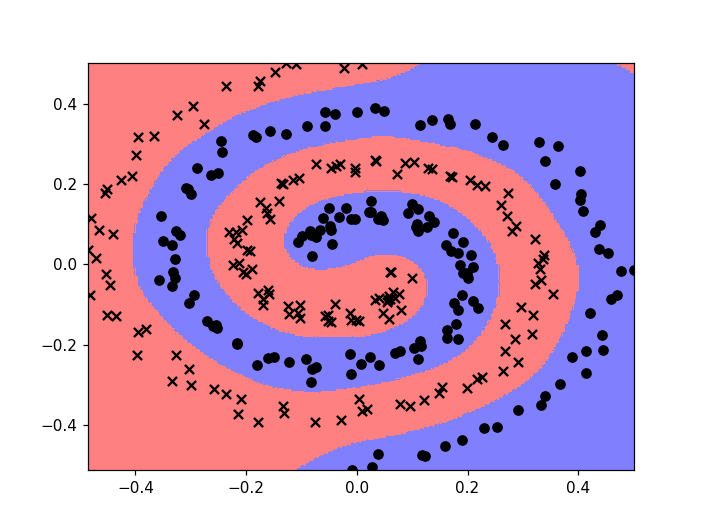

Training error: 0.0000
Testing error: 0.0033


In [213]:
xTr,yTr,xTe,yTe=spiraldata()
ktype="rbf"
svmclassify=dualSVM(xTr, yTr, kernel_type=ktype, num_epochs=1000, C=1, lmbda=100, lr=1e-3)

visclassifier.visclassifier(svmclassify,xTr,yTr)
# compute training and testing error
predsTr=svmclassify(xTr)
trainingerr=torch.mean((torch.sign(predsTr)!=yTr).float())
print("Training error: %2.4f" % trainingerr)

predsTe=svmclassify(xTe)
testingerr=torch.mean((torch.sign(predsTe)!=yTe).float())
print("Testing error: %2.4f" % testingerr)

SVMs are pretty sensitive to hyper-parameters. We ask you to implement a cross-validation function. <code>cross_validation</code> which takes training data <code>xTr</code>, training labels <code>yTr</code>, validation data <code>xValid</code>, validation labels <code>yValid</code>, kernel type <code>ktype</code>, list of possible C values <code>CList</code>, list of lambda values for kernel generation <code>lmbdaList</code>, and list of learning rates <code>lr_list</code>.

Note that we don't have <code>epochs</code> as a hyper-parameter to tune even, though the number of epochs we train on can vastly change the performance of our model. Generally we train with gradient descent <b>until convergence</b> (when train/validation loss stop decreasing); therefore, something you can do to get a good idea of what amount of epochs you need is plot [epoch number x (training,validation)] loss! <b>This part will not be tested</b>, but is something that might help. 

In [ ]:
#<GRADED>
def cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList,lr_List):
    """
    function bestC,bestLmbda,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,ktype,CList,lmbdaList);
    Use the parameter search to find the optimal parameter,
    Individual models are trained on (xTr,yTr) while validated on (xValid,yValid)
    
    Input:
        xTr      | training data (nxd)
        yTr      | training labels (nx1)
        xValid   | training data (mxd)
        yValid   | training labels (mx1)
        ktype    | the type of kernelization: 'rbf','polynomial','linear'
        CList    | The list of values to try for the SVM regularization parameter C (ax1)
        lmbdaList| The list of values to try for the kernel parameter lmbda- degree for poly, inverse width for rbf (bx1)
        lr_list  | The list of values to try for the learning rate of our optimizer
    
    Output:
        bestC      | the best C parameter
        bestLmbda  | the best Lmbda parameter
        bestLr     | the best Lr parameter
        ErrorMatrix| the test error rate for each given (C, Lmbda Lr) tuple when trained on (xTr,yTr) and tested on (xValid,yValid)
    """
    
    raise NotImplementedError("your code goes here!")
    
    return bestC,bestLmbda,bestLr,ErrorMatrix
#</GRADED>

In [ ]:
xTr,yTr,xValid,yValid=spiraldata(100)
CList=(2.0**np.linspace(-1,5,7))
lmbdaList=(np.linspace(0.1,0.5,5))
lrList=(np.linspace(0.001,0.005,5))

bestC,bestLmbda,bestLr,ErrorMatrix = cross_validation(xTr,yTr,xValid,yValid,'rbf',CList,lmbdaList,lrList)

Competition: we ask you to implement function autosvm, which given xTr and yTr, splits them into training data and validation data, and then uses a hyperparameter search to find the optimal hyper parameters. 

Function autosvm should return a function which will act as a classifier on xTe.

You have a 5 minute time limit on multiple datasets, each dataset having different optimal hyperparameters, so you should strive for a good method of finding hyperparameters (within the time limit) instead of just trying to find a static set of good hyperparameters. 

You will get extra credit for the competition if you can beat the base benchmark of 34% error rate.

In [ ]:
#<GRADED>
def autosvm(xTr,yTr):
    
    return

#</GRADED>